# Spam Detection
- https://wikidocs.net/22894

## Import

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

## Load dataset

In [32]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')
len(data)

5572

In [33]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Data Preprocessing

In [34]:
data = data[["v1", "v2"]]
data["v1"] = data["v1"].replace(["ham", "spam"], [0, 1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null int64
v2    5572 non-null object
dtypes: int64(1), object(1)
memory usage: 87.1+ KB


In [36]:
data.isnull().values.any()

False

In [37]:
len(data["v1"].unique()), len(data["v2"].unique())

(2, 5169)

In [38]:
data.drop_duplicates(subset=["v2"], inplace=True)
len(data)

5169

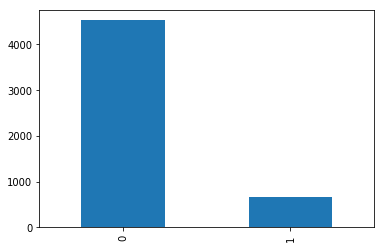

In [39]:
data['v1'].value_counts().plot(kind='bar')

In [40]:
data.groupby("v1").size().reset_index(name = "count")

,v1,count
0,0,4516
1,1,653


In [41]:
x_data = data["v2"]
y_data = data["v1"]
len(x_data), len(y_data)

(5169, 5169)

In [42]:
x_data[:5]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

## Text Preprocessing

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_data)
sequences = tokenizer.texts_to_sequences(x_data)
sequences[0]

[47,
 433,
 4013,
 780,
 705,
 662,
 64,
 8,
 1202,
 94,
 121,
 434,
 1203,
 142,
 2712,
 1204,
 68,
 57,
 4014,
 137]

In [45]:
word2index = tokenizer.word_index
len(word2index) #빈도수가 높은 단어가 낮은 index를 가진다.

8920

In [46]:
threshold = 2
total_cnt = len(word2index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


In [47]:
vocab_size = len(word2index) + 1#padding(0)을 위해서 1개 추가
vocab_size

8921

In [48]:
num_of_train = int(len(sequences) * 0.8)
num_of_test = int(len(sequences) - num_of_train)
num_of_train, num_of_test

(4135, 1034)

메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


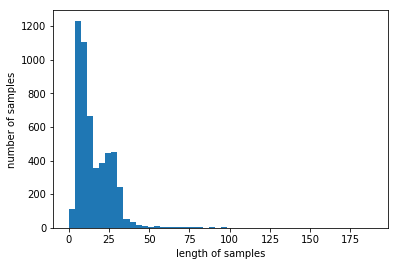

In [49]:
x_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in x_data))
print('메일의 평균 길이 : %f' % (sum(map(len, x_data))/len(x_data)))
plt.hist([len(s) for s in x_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춘다.
data = pad_sequences(x_data, maxlen=max_len)
data.shape

(5169, 189)

In [52]:
x_train = data[:num_of_train]
y_train = np.array(y_data[:num_of_train])
x_test = data[num_of_train:]
y_test = np.array(y_data[num_of_train:])
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4135, 189), (4135,), (1034, 189), (1034,))

## Text classification to detect spam mail

In [57]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [59]:
history = model.fit(
    x_train,
    y_train,
    epochs=4,
    batch_size=64,
    validation_split=0.2
)

Train on 3308 samples, validate on 827 samples
Epoch 1/4
3308/3308 [==============================] - 3s 939us/sample - loss: 0.2988 - acc: 0.9021 - val_loss: 0.1515 - val_acc: 0.9541
Epoch 2/4
3308/3308 [==============================] - 2s 613us/sample - loss: 0.1178 - acc: 0.9683 - val_loss: 0.0799 - val_acc: 0.9794
Epoch 3/4
3308/3308 [==============================] - 2s 613us/sample - loss: 0.0620 - acc: 0.9831 - val_loss: 0.0662 - val_acc: 0.9807
Epoch 4/4
3308/3308 [==============================] - 2s 622us/sample - loss: 0.0389 - acc: 0.9897 - val_loss: 0.0618 - val_acc: 0.9807


In [63]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Accuracy: {acc}")

1034/1 - 0s - loss: 0.0336 - acc: 0.9836
Accuracy: 0.9835590124130249


## Visualization

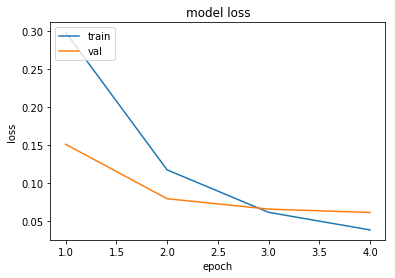

In [64]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()